In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Helpers.preprocess.main import *
from Helpers.models.simple_ml import *
from Helpers.preprocess.content_based_features import get_content_based_features
from Helpers.preprocess.host_based_features import get_host_based_features
from Helpers.preprocess.lexical_url_features import get_lexical_url_features
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
import sys
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import string

In [18]:
df = pd.read_csv("Data/malicious_phish.csv")

In [19]:
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [15]:
import seaborn as sns
sns.set()

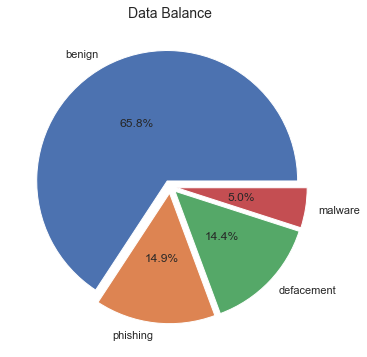

In [17]:
pie, ax = plt.subplots(figsize=[10,6])
labels = df["type"].unique()
plt.pie(x=df["type"].value_counts(), autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Data Balance", fontsize=14);
pie.savefig("databalance.png")

<AxesSubplot:>

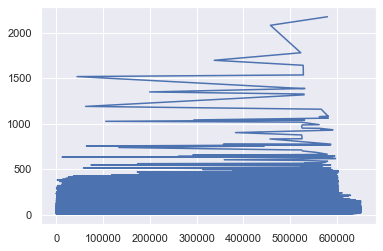

In [25]:
# lens = df["url"].swifter.apply(len)
lens = lens.sort_values()
plt.scatter

In [ ]:
# df = preprocess(cache=False,features_extractors=(get_lexical_url_features,),save_to_path="./small_clean.csv",data_path="small.csv")

In [ ]:
chars = sorted(list(set(string.printable)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
n_chars = len(raw_text)
n_vocab = len(chars)
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print "Total Patterns: ", n_patterns
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [ ]:
filename = "weights-improvement-47-1.2219-bigger.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print "\"", ''.join([int_to_char[value] for value in pattern]), "\""
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print "\nDone."

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
df["type"] = pd.Categorical(df["type"]).codes
X = df["url"]
y = df["type"]

## Gan

In [ ]:
#!/usr/bin/python3

from __future__ import print_function, division
from tensorflow.contrib.keras.api.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.contrib.keras.api.keras.layers import BatchNormalization, Activation
from tensorflow.contrib.keras.api.keras.layers import LeakyReLU, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.contrib.keras.api.keras.models import Sequential, Model
from tensorflow.contrib.keras.api.keras.optimizers import Adam, RMSprop
from tensorflow.contrib.keras.api.keras.backend import expand_dims
from tensorflow.contrib.keras.api.keras.layers import UpSampling1D, Conv1D, LocallyConnected1D
from tensorflow.contrib.keras.api.keras.activations import softmax
import tensorflow as tf
import argparse
import string
import sys
import numpy as np

# Disable Warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Constants
save_interval = 100
learning_rate=0.0002

noise_shape=(8,)
epochs = 1000
input_data = ""
print_size = 128
batch_size = 200
url_len = 200
generator_layers = "8:8"
discriminator_layers = "8:4:2"
generator_activation = "tanh"
discriminator_activation = "tanh"
dropout_value = 0.8
discriminator_savefile = "discriminator_savefile"
generator_savefile = "generator_savefile"


# Define Alphabet
alphabet = string.ascii_lowercase + string.digits + "/:._-()=;?&" # MUST BE EVEN
dictionary_size = len(alphabet) + 1
url_shape = (url_len, dictionary_size)

In [9]:
def build_generator_dense():
    model = Sequential()
    first = True
    for size in generator_layers.split(":"):
        size = int(size)
        if first:
            model.add(Dense(size, input_shape=noise_shape, activation=generator_activation))
        else:
            model.add(Dense(size, activation=generator_activation))

        model.add(Dropout(dropout_value))
        first = False
    model.add(Dense(size, input_shape=noise_shape, activation=generator_activation))
    model.add(Dense(size, activation=generator_activation))
    model.add(Dropout(dropout_value))
    model.add(Dense(size, activation=generator_activation))
    model.add(Dense(  np.prod(url_shape) , activation="tanh"))
    model.add(Dropout(dropout_value))
    model.add(Reshape(url_shape))
    model.summary()

    noise = Input(shape=noise_shape)
    gen = model(noise)

    return Model(noise, gen)

def build_discriminator_dense():
    model = Sequential()
    model.add(Flatten(input_shape=url_shape))
    # Add arbitrary layers
    for size in discriminator_layers.split(":"):
        size = int(size)
        model.add(Dense(size, activation=discriminator_activation))
        model.add(Dropout(dropout_value))
    # Add the final layer, with a single output
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    gen = Input(shape=url_shape)
    validity = model(gen)
    return Model(gen, validity)


In [ ]:
build_generator = build_generator_dense
build_discriminator = build_discriminator_dense

dictionary = {}
reverse_dictionary = {}
for i, c in enumerate(alphabet):
    dictionary[c]=i+1
    reverse_dictionary[i+1]=c

# Build Oprimizer
optimizer = Adam(learning_rate, 0.5)

print ("*** BUILDING DISCRIMINATOR ***")
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy'])

print ("*** BUILDING GENERATOR ***")
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=noise_shape)
gen = generator(z)

discriminator.trainable = False

valid = discriminator(gen)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


data = []   
for line in open(input_data,"r").read().splitlines():
    this_sample=np.zeros(url_shape)

    line = line.lower()
    if len ( set(line) - set(alphabet)) == 0 and len(line) < url_len:
        for i, position in enumerate(this_sample):
            this_sample[i][0]=1.0

        for i, char in enumerate(line):
            this_sample[i][0]=0.0
            this_sample[i][dictionary[char]]=1.0
        data.append(this_sample)
    else:
        print("Uncompatible line:",  line)

print("Data ready. Lines:", len(data))
X_train = np.array(data)
print ("Array Shape:", X_train.shape)
half_batch = int(batch_size / 2)


In [ ]:
# Start Training
for epoch in range(epochs):
    # Select a random half batch of data
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    samples = X_train[idx]
    noise_batch_shape = (half_batch,) + noise_shape
    noise = np.random.normal(0, 1, noise_batch_shape)

    # Generate a half batch of new data
    gens = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(samples, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gens, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise_batch_shape = (batch_size,) + noise_shape
    noise = np.random.normal(0, 1, noise_batch_shape)

    valid_y = np.array([1] * batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)

    print ("%d [D loss: %0.3f, acc.: %0.3f%%] [G loss: %0.3f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch % save_interval == 0:
        generated_samples=[]
        r, c = 5, 5
        noise_batch_shape = (print_size,) + noise_shape
        noise = np.random.normal(0, 1, noise_batch_shape)
        gens = generator.predict(noise)

        for url in gens:
            this_url_gen = ""
            for position in url:
                this_index = np.argmax(position)
                if this_index != 0:
                    this_url_gen += reverse_dictionary[this_index]

            print(this_url_gen)
            generated_samples.append(this_url_gen)

discriminator.save(discriminator_savefile)
generator.save(generator_savefile)

# Save Samples
fo = open(generated_savefile, "w")
for url in generated_samples:
    print (url, file=fo)
fo.close()